In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

In [2]:
df = pd.read_csv('../../datasets/cardekho.csv')

In [3]:
df.isnull().sum()

name                    0
year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             216
seats                 221
dtype: int64

In [16]:
df['brand'] = df['name'].str.split().str[0]
brand_avg_price = df.groupby('brand')['selling_price'].mean().to_dict()
df['average_brand_price'] = df['brand'].map(brand_avg_price)
#--------------------------------------------------------------------------------------------------------------------------------------------------
df_cleaned = df.dropna()
df_cleaned.isnull().sum()
# df_cleaned.to_csv("car.csv", index=False)
# df_cleaned.head()

name                   0
year                   0
selling_price          0
km_driven              0
fuel                   0
seller_type            0
transmission           0
owner                  0
mileage(km/ltr/kg)     0
engine                 0
max_power              0
seats                  0
brand                  0
average_brand_price    0
dtype: int64

In [5]:
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner'] #categorical
num_cols = ['year', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats'] # numerical

preprocessor = ColumnTransformer( # It allows you to perform different preprocessing methods on different columns.
    transformers=[
        ('num', StandardScaler(), num_cols), # average = 0, variance = 1
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

In [6]:
# X = df_cleaned.drop(['name', 'selling_price'], axis=1)
X = df_cleaned[num_cols + cat_cols]
y = df_cleaned['selling_price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'km_driven',
                                                   'mileage(km/ltr/kg)',
                                                   'engine', 'max_power',
                                                   'seats']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fuel', 'seller_type',
                                                   'transmission',
                                                   'owner'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [9]:
y_pred =model.predict(X_test)
print(r2_score(y_test, y_pred))

0.9836785760886291


# predict price 👇

In [10]:
# new_car = pd.DataFrame({
#     'year': [2014], 'km_driven': [145500], 'fuel': ['Diesel'], 'seller_type': ['Individual'],
#     'transmission': ['Manual'], 'owner': ['First Owner'], 'mileage(km/ltr/kg)': [23.40],
#     'engine': [1248.0], 'max_power': [74.00], 'seats': [5]
# })
# predicted_price = model.predict(new_car)
# print(predicted_price)
df_cleaned['predicted_price'] = model.predict(X)
df_cleaned.head()
# df_cleaned.to_csv("car.csv", index=False)



C:\Users\aa\AppData\Local\Temp\ipykernel_12140\3929954178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['predicted_price'] = model.predict(X)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,brand,average_brand_price,predicted_price
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti,403075.721405,514337.420000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda,607723.771429,418433.333333
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda,596178.014989,158134.000000
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai,458554.366784,243470.000000
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti,403075.721405,154650.000000


In [11]:
importances = model.named_steps['regressor'].feature_importances_
feature_names = num_cols + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
print(pd.Series(importances, index=feature_names).sort_values(ascending=False))

max_power                       0.710302
year                            0.213032
km_driven                       0.019765
mileage(km/ltr/kg)              0.019091
engine                          0.016653
seats                           0.005159
seller_type_Dealer              0.003914
seller_type_Individual          0.003719
fuel_Diesel                     0.002088
fuel_Petrol                     0.001629
transmission_Manual             0.001354
transmission_Automatic          0.001143
owner_Second Owner              0.000838
owner_First Owner               0.000837
owner_Third Owner               0.000158
owner_Test Drive Car            0.000144
seller_type_Trustmark Dealer    0.000086
owner_Fourth & Above Owner      0.000077
fuel_LPG                        0.000007
fuel_CNG                        0.000003
dtype: float64


# Days to sell

In [ ]:
# Calculate the percentage difference: (predicted_price - average_brand_price) / average_brand_price * 100
df_cleaned['percent_diff'] = (abs(df_cleaned['predicted_price'] - df_cleaned['average_brand_price']) / df_cleaned['average_brand_price']) * 100
df_cleaned['days_to_sell'] = df_cleaned['percent_diff'] / 1
df_cleaned['days_to_sell'] = df_cleaned['days_to_sell'].apply(lambda x: max(0, x))
# Create a binary column: True if sells in 30 days or less, False otherwise
df_cleaned['sells_in_30_days'] = df_cleaned['days_to_sell'] <= 30

df_cleaned.tail() 

C:\Users\aa\AppData\Local\Temp\ipykernel_12140\2647901669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['percent_diff'] = (abs(df_cleaned['predicted_price'] - df_cleaned['average_brand_price']) / df_cleaned['average_brand_price']) * 100
C:\Users\aa\AppData\Local\Temp\ipykernel_12140\2647901669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['days_to_sell'] = df_cleaned['percent_diff'] / 1
C:\Users\aa\AppData\Local\Temp\ipykernel_12140\2647901669.py:4: SettingWithCopyWarning: 

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,brand,average_brand_price,predicted_price,percent_diff,days_to_sell,sells_in_30_days
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0,Hyundai,458554.366784,333049.99,27.369574,27.369574,True
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,5.0,Hyundai,458554.366784,141400.00,69.163962,69.163962,False
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.30,1248.0,73.90,5.0,Maruti,403075.721405,331769.98,17.690408,17.690408,True
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396.0,70.00,5.0,Tata,357433.107629,286040.00,19.973837,19.973837,True
8127,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396.0,70.00,5.0,Tata,357433.107629,286040.00,19.973837,19.973837,True


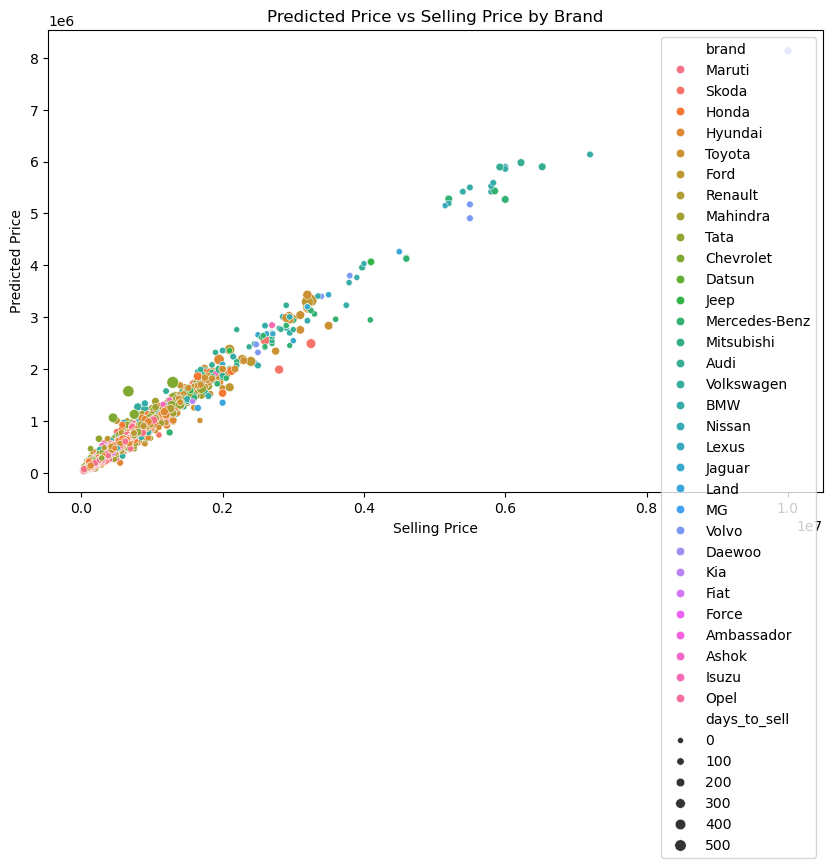

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='selling_price', y='predicted_price', hue='brand', size='days_to_sell')
plt.title('Predicted Price vs Selling Price by Brand')
plt.xlabel('Selling Price')
plt.ylabel('Predicted Price')
plt.show()

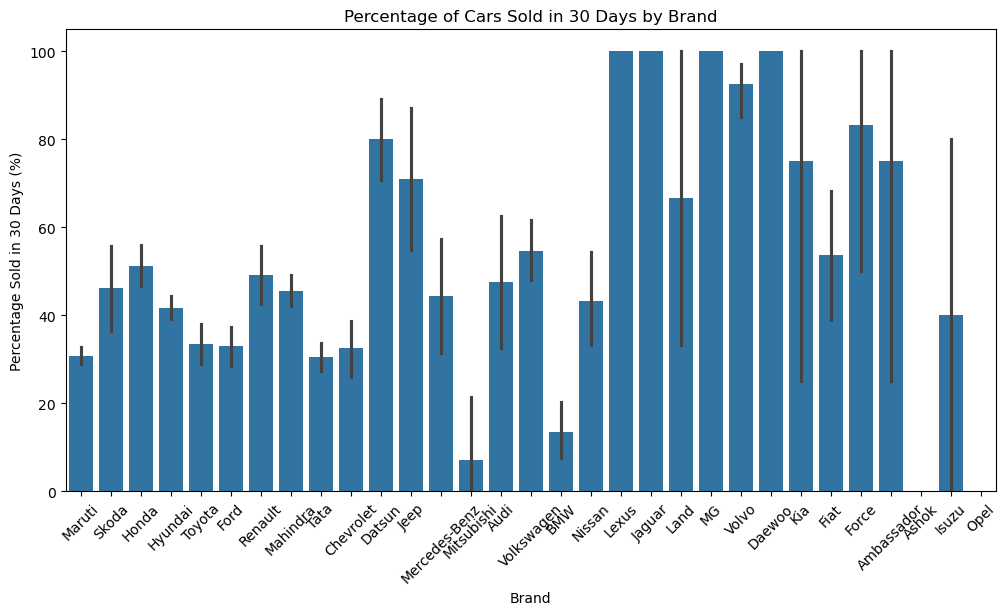

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_cleaned, x='brand', y='sells_in_30_days', estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Percentage of Cars Sold in 30 Days by Brand')
plt.xlabel('Brand')
plt.ylabel('Percentage Sold in 30 Days (%)')
plt.xticks(rotation=45)
plt.show()

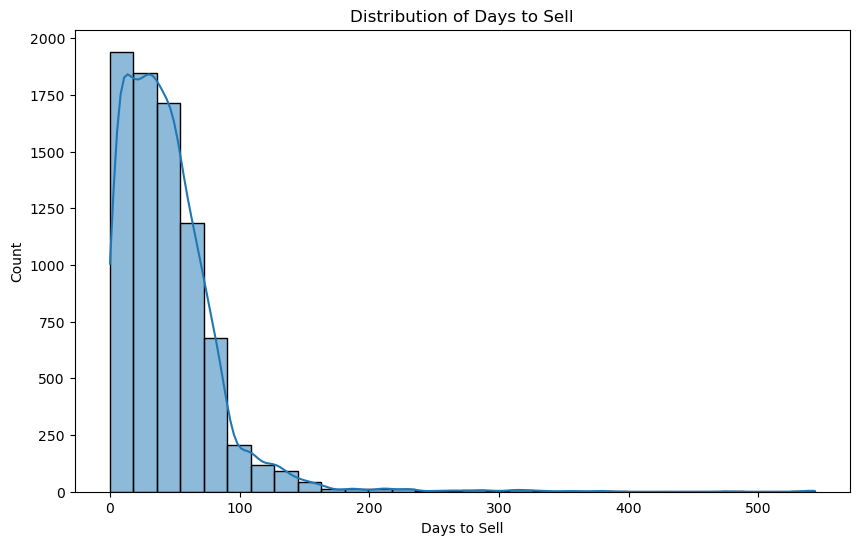

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='days_to_sell', bins=30, kde=True)
plt.title('Distribution of Days to Sell')
plt.xlabel('Days to Sell')
plt.ylabel('Count')
plt.show()